In [6]:
#Library for calling python functions
library(reticulate)
#Library for calling DropNA function
library(DataCombine)

#Movies_data contains info of more than 9k movies
movies_data  <- read.csv("movie.csv")
#Ratings_data contains more than 100k ratings provided by users
ratings_data <- read.csv("ratings.csv")


In [7]:
#Dropping NA values from Ratings dataset
ratings_data <- DropNA(ratings_data, message = FALSE)
#Dropping NA values from Movies dataset
movies_data <- DropNA(movies_data, message = FALSE)

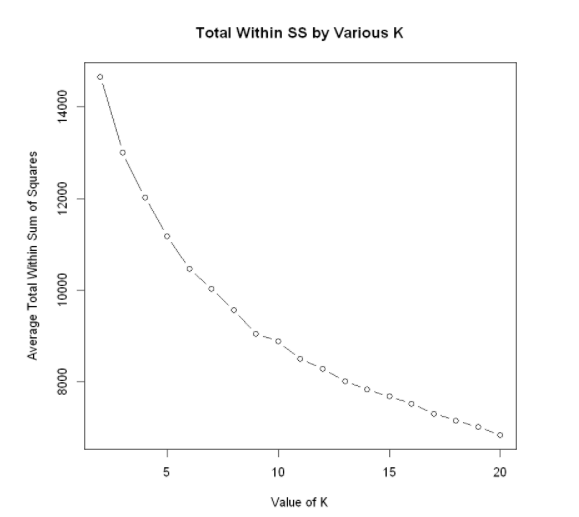

In [8]:
getMoviesList<-function(movies_data,ratings_data,user_id)
{
    #setting seed for avoiding random values
    set.seed(123)
    
    #getting rid of movie ids and titles
    movies_data1<-movies_data[,c(-1,-2)]
    
    #We got n=9 from above where we calculated 9 as optimal number of clusters using Elbow Method
    movieCluster<-kmeans(movies_data1,9)

    #Select all rows from ratings_data that have the userid==user_id and keep the columns itemid & rating
    a<-subset(ratings_data, userid==user_id,select=c(itemid, rating))
    
    # allocate 0 to the cluster column
    cluster<-0
    activeUser <<- data.frame( a[order(a$itemid),] ,cluster)

    # set up temporary dataframe to match cluster assignments to movie ids
    df1<- data.frame(cbind(movies_data$movid, clusterNum = movieCluster$cluster))
    names(df1)<-c("movie_id", "cluster")
    
    #This matches the cluster number to the activeUser movie id
    activeUser$cluster<-df1[match(activeUser$itemid, df1$movie_id),2]

    #aggregate() function is used along with the cluster memberships to determine variable means for each cluster in the original metric
    like<-aggregate(activeUser$rating, by=list(cluster=activeUser$cluster), mean)
    
    #A bit different approach here: If the max mean rating is below three it gives out the dummy value zero
    if(max(like$x)<3)
    {
        like<-as.vector(0)
    } 
    #Else it gives out the cluster number of the max mean value
    else
    {
        like<-as.vector(t(max(subset(like, x>=3, select=cluster))))
    }

    # Again a temporary dataframe is created to get a list of all movies and their associated clusters
    df1<- data.frame(cbind(movies_data$movid, clusterNum = movieCluster$cluster))
    names(df1)<-c("movie_id", "cluster")
    
    #if like has the value zero it selects randomly 100 movies
    if(like==0)
    {
        recommend<-movies_data[sample.int(n = dim(movies_data)[1], size = 100), 1]
    }
    #else it selects all movies from the winning max mean cluster
    else
    {
        recommend<-as.vector(t(subset(df1, cluster==like, select=movie_id)))
    }
    return(recommend)
    
}

In [9]:
RecommendMovies<-function(movies_data, ratings_data, userid, no_films)
{
    #calling the get films function that will return the list of recommended movies for the entered used_id
    recommend<-getMoviesList(movies_data,ratings_data,userid)
    
    # only selecting unwatched movies
    recommend<-recommend[-activeUser$itemid]
    
    # adding movietitle
    movtitle<-movies_data[match(recommend,movies_data$movid),2]
    
    #getting suggestions on sequel choices
    suggestions <-data.frame(recommend,movtitle)
    source_python('sequel.py')
    
    #here priority contains the sequel whose prequels are really liked by user
    priority<-sequel_recommender(userid)
    
    #selecting n number of selections entered in suggestFilms function
    suggestions = suggestions[1:no_films,]
    writeLines("You may also like these movies:")
    
    #printing suggestions without any column headers or row indices
    write.table(suggestions[2], row.names = FALSE, col.names = FALSE)
    write.table(priority,row.names = FALSE, col.names = FALSE)
}

In [10]:
RecommendMovies(movies_data, ratings_data, 71, 15)

You may also like these movies:
"Cutthroat Island (1995)"
"City of Lost Children, The (CitÃ© des enfants perdus, La) (1995)"
"Mortal Kombat (1995)"
"White Squall (1996)"
"Broken Arrow (1996)"
"Hackers (1995)"
"Waterworld (1995)"
"Star Wars: Episode IV - A New Hope (1977)"
"Stargate (1994)"
"Star Trek: Generations (1994)"
"True Lies (1994)"
"Street Fighter (1994)"
"Cliffhanger (1993)"
"Demolition Man (1993)"
"Jurassic Park (1993)"
"Jumanji: Welcome to the Jungle (2017)"
"Ever After: A Cinderella Story (1998)"
"Cinderella Story, A (2004)"
"Cinderella Man (2005)"
"Cinderella (1997)"
"Another Cinderella Story (2008)"
"Cinderella (2015)"
"Underworld (2003)"
"Underworld: Evolution (2006)"
"Underworld: Rise of the Lycans (2009)"
"Underworld: Awakening (2012)"
"Underworld: Blood Wars (2016)"
